In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install albumentations

import numpy as np
from PIL import Image
import glob
import cv2
import os
from os.path import join as pjoin
from pdb import set_trace
import copy
import scipy

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset, WeightedRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
from torchvision.models.alexnet import model_urls
try:
  from torchvision.models.utils import load_state_dict_from_url
except ImportError:
  from torch.hub import load_state_dict_from_url

import albumentations as albu
from albumentations.pytorch import ToTensorV2

# Detect if we have a GPU available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/kaggle/input/mydataset/dataset/content_image/Tuebingen_Neckarfront.jpg
/kaggle/input/mydataset/dataset/style_image/vangogh_starry_night.jpg
/kaggle/input/mydataset/dataset/style_image/van_gogh_the_scream.jpg
/kaggle/input/datasetstyle/dataset/content_image/Tuebingen_Neckarfront.jpg
/kaggle/input/datasetstyle/dataset/style_image/van_gogh_the_scream.jpg


# My implementation of the paper "A neural algorithm of artistic style" by Leon A. Gatys et al.

At first I thought that the trainable image would be created from random values, but it turns out that the authors implemented it by using the content image as the initial values: https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb


In [2]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [3]:
# Load content and style image
dataset_path = "/kaggle/input/datasetstyle/dataset"
content_img = cv2.imread(pjoin(dataset_path, "content_image", "Tuebingen_Neckarfront.jpg"))
style_img = cv2.imread(pjoin(dataset_path, "style_image", "van_gogh_the_scream.jpg"))

content_img = content_img.astype(np.float32)
style_img = style_img.astype(np.float32)

content_img /= 255.0
style_img /= 255.0

content_img = cv2.resize(content_img, (1024, 1024), interpolation=cv2.INTER_CUBIC)
style_img = cv2.resize(style_img, (1024, 1024), interpolation=cv2.INTER_CUBIC)

In [4]:
content_img.shape

(1024, 1024, 3)

In [5]:
style_img.shape

(1024, 1024, 3)

In [6]:
display(content_img)

array([[[0.4487477 , 0.32774204, 0.20673637],
        [0.48404184, 0.34734988, 0.26948148],
        [0.47732463, 0.35575595, 0.22634421],
        ...,
        [0.6745098 , 0.45518345, 0.23865272],
        [0.67479134, 0.45546493, 0.2389342 ],
        [0.6829159 , 0.47199562, 0.25546494]],

       [[0.4276999 , 0.3028378 , 0.17668314],
        [0.46644074, 0.32416895, 0.24330576],
        [0.44339383, 0.3226869 , 0.19327512],
        ...,
        [0.6732173 , 0.45196268, 0.24294004],
        [0.6711397 , 0.4498851 , 0.24086246],
        [0.6773361 , 0.45890775, 0.24988513]],

       [[0.43404183, 0.2975988 , 0.16591223],
        [0.4595818 , 0.3125881 , 0.21826556],
        [0.45076975, 0.32585785, 0.19644609],
        ...,
        [0.67797375, 0.4514457 , 0.25215995],
        [0.6719497 , 0.44542164, 0.24613588],
        [0.6726141 , 0.44522443, 0.24645565]],

       ...,

       [[0.08512753, 0.09297067, 0.09271216],
        [0.08503179, 0.09287493, 0.09287493],
        [0.06153684, 0

In [7]:
# Load pre-trained VGG19 model
pretrained_model = torchvision.models.vgg19(pretrained=True)


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [8]:
pretrained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:
rand_inp = torch.FloatTensor(1, 3, 256, 256)
out = pretrained_model(rand_inp)

In [10]:
out.shape

torch.Size([1, 1000])

In [11]:
# Remove the FC layer
pretrained_model.classifier = nn.Identity()

In [12]:
pretrained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [13]:
out = pretrained_model(rand_inp)
out.shape

torch.Size([1, 25088])

In [14]:
pretrained_model.features[1]

ReLU(inplace=True)

In [15]:
pretrained_model.features.requires_grad_(False)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [16]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
pretrained_model.features[0].register_forward_hook(get_activation('conv1_1'))
pretrained_model.features[5].register_forward_hook(get_activation('conv2_1'))
pretrained_model.features[10].register_forward_hook(get_activation('conv3_1'))
pretrained_model.features[19].register_forward_hook(get_activation('conv4_1'))
pretrained_model.features[28].register_forward_hook(get_activation('conv5_1'))

pretrained_model.features[21].register_forward_hook(get_activation('conv4_2'))

out = pretrained_model(rand_inp)

In [17]:
activation['conv1_1'].shape

torch.Size([1, 64, 256, 256])

In [18]:
activation['conv2_1']

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3587e-01,
           2.2629e-01, 0.0000e+00],
          [2.7443e+32, 0.0000e+00, 0.0000e+00,  ..., 4.7889e-01,
           5.1485e-01, 0.0000e+00],
          [2.9870e+32, 1.2324e+32, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7798e-01, 3.8841e-03, 4.2562e-01,  ..., 4.2562e-01,
           6.4544e-01, 2.1072e-01],
          [3.1208e-01, 1.3984e-02, 4.3640e-01,  ..., 4.3640e-01,
           6.3375e-01, 2.1697e-01],
          [4.3911e-01, 0.0000e+00, 2.9366e-01,  ..., 2.9366e-01,
           4.6694e-01, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.4583e+32, 1.5690e+32, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.8052e+31, 1.2234e+32, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000

In [19]:
activation['conv2_1'].shape

torch.Size([1, 128, 128, 128])

In [20]:
activation['conv3_1'].shape

torch.Size([1, 256, 64, 64])

In [21]:
activation['conv4_1'].shape

torch.Size([1, 512, 32, 32])

In [22]:
activation['conv5_1'].shape

torch.Size([1, 512, 16, 16])

In [23]:
alpha = 10**-3
alpha

0.001

In [24]:
# Code for a neural algorithm of artistic style
class NeuralStyleTransfer(nn.Module):
    def __init__(self):
        wl_list = [1/5, 1/5, 1/5, 1/5, 1/5]
        alpha = 10**-3
        beta = 1
        
        self.wl_list = wl_list
        self.alpha = alpha
        self.beta = beta
        pass
    
    def forward(self, x):
        pass

In [25]:
from pdb import set_trace
from collections import OrderedDict

# Hyperparameter settings
n_epoch = 50000
learning_rate = 0.01
# learning_rate = 0.0001
# wl_list = [1/5, 1/5, 1/5, 1/5, 1/5]
# wl_list = [50, 1/5, 1/5, 1/5, 1/5]
wl_list = [1.5, 0.8, 0.25, 0.25, 0.25]
# wl_list = [1e3/n**2 for n in [64,128,256,512,512]]
# wl_list = [0.25, 0.25, 0.25, 0.8, 2.5]
# wl_list = [0.5, 0.5, 0.8, 5, 1000]
# wl_list = [100, 0.8, 0.25, 0.25, 0.25]
# wl_list = [1, 0, 0, 0, 0]

#alpha = 0.0001
alpha = 1e-1
beta = 1
content_layer_list = ["conv4_2"]
style_layer_list = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]

# Load pre-trained VGG19 model, remove FC layers and replace max-pooling by average pooling
# pretrained_model = torchvision.models.vgg19(pretrained=True)
pretrained_model = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)
pretrained_model.classifier = nn.Identity()
pretrained_model.features.requires_grad_(False)
for i, layer in pretrained_model.features.named_children():
    if isinstance(layer, torch.nn.MaxPool2d):
        pretrained_model.features[int(i)] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        
        
# activation = {}
activation = OrderedDict()
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook
pretrained_model.features[0].register_forward_hook(get_activation('conv1_1'))
pretrained_model.features[5].register_forward_hook(get_activation('conv2_1'))
pretrained_model.features[10].register_forward_hook(get_activation('conv3_1'))
pretrained_model.features[19].register_forward_hook(get_activation('conv4_1'))
pretrained_model.features[28].register_forward_hook(get_activation('conv5_1'))

pretrained_model.features[21].register_forward_hook(get_activation('conv4_2'))

# Load the style and content images
# dataset_path = "/kaggle/input/datasetstyle/dataset"
# content_img = cv2.imread(pjoin(dataset_path, "content_image", "Tuebingen_Neckarfront.jpg"))
# style_img = cv2.imread(pjoin(dataset_path, "style_image", "van_gogh_the_scream.jpg"))

dataset_path = "/kaggle/input/mydataset/dataset"
content_img = cv2.imread(pjoin(dataset_path, "content_image", "Tuebingen_Neckarfront.jpg"))
style_img = cv2.imread(pjoin(dataset_path, "style_image", "vangogh_starry_night.jpg"))

content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)
style_img = cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB)

content_img = cv2.resize(content_img, (512, 512), interpolation=cv2.INTER_CUBIC)
style_img = cv2.resize(style_img, (512, 512), interpolation=cv2.INTER_CUBIC)

content_img = content_img.astype(np.float32)
style_img = style_img.astype(np.float32)
content_img /= 255.0
style_img /= 255.0

content_img = content_img[np.newaxis, :, :, :]
style_img = style_img[np.newaxis, :, :, :]

content_img_torch = torch.from_numpy(content_img)
style_img_torch = torch.from_numpy(style_img)

content_img_torch = torch.swapaxes(content_img_torch, 3, 1)
style_img_torch = torch.swapaxes(style_img_torch, 3, 1)

# Set up trainable input parameter here
trainable_input = nn.Parameter(torch.rand((1, 3, 512, 512)).clone().requires_grad_(True).cuda())
# trainable_input = nn.Parameter(content_img_torch.clone().requires_grad_(True).cuda())
# set_trace()
content_img_torch = content_img_torch.cuda()
style_img_torch = style_img_torch.cuda()

# Set up optimizer
opt = optim.Adam([trainable_input.requires_grad_()], lr=learning_rate)

# Dictionaries to store intermedate outputs
style_dict = {}
content_dict = {}
input_dict = {}

# We only need to send the content and style image through the pretrained network once
pretrained_model.cuda()
out = pretrained_model(content_img_torch)
content_dict = activation.copy()
out = pretrained_model(style_img_torch)
style_dict = activation.copy()    
    
for epoch_idx in range(1, n_epoch+1):
    # correct the values of updated input image
    with torch.no_grad():
        trainable_input.clamp_(0, 1)

    # Let the trainable input pass through 
    out = pretrained_model(trainable_input)
    input_dict = activation.copy()

    # Calculate the content loss
#    out = pretrained_model(content_img_torch)
#    content_dict = activation.copy()

    content_loss = 0
    for content_layer in content_layer_list:
        Pl = content_dict[content_layer]
        Fl = input_dict[content_layer]
        rms_loss = nn.MSELoss()
        loss_val = rms_loss(Pl, Fl)
        content_loss += loss_val  

    # Now, let the style image run through, then we calculate the style loss
    out = pretrained_model(style_img_torch)
    style_dict = activation.copy()

    style_loss = 0
    for style_layer, wl in zip(style_layer_list, wl_list):
        Pl = style_dict[content_layer]
        Fl = input_dict[content_layer]

        Pl = Pl.reshape(Pl.shape[0], Pl.shape[1], -1)
        Fl = Fl.reshape(Fl.shape[0], Fl.shape[1], -1)

        n_filter = Pl.shape[1]
        feature_map_size = Pl.shape[2]

        Pl_gram = torch.bmm(Pl, torch.swapaxes(Pl, 2, 1))
        Fl_gram = torch.bmm(Fl, torch.swapaxes(Pl, 2, 1))

        rms_loss = nn.MSELoss()
        loss_val = rms_loss(Pl_gram, Fl_gram)
        loss_val /= 2.0
        loss_val /= (1.0* (n_filter*feature_map_size))
        loss_val *= wl

        style_loss += loss_val

    # Calculate total loss and update the trainable parameters accordingly
    total_loss = alpha*content_loss + beta*style_loss

    opt.zero_grad()
    total_loss.backward()  
    opt.step()

    if (epoch_idx % 50 == 0):
        print("Epoch: %d. Loss: %f" % (epoch_idx, total_loss.item()))
        # print(total_loss)      

Epoch: 50. Loss: 0.036419
Epoch: 100. Loss: 0.029476
Epoch: 150. Loss: 0.027188
Epoch: 200. Loss: 0.026165
Epoch: 250. Loss: 0.025603
Epoch: 300. Loss: 0.025233
Epoch: 350. Loss: 0.024962
Epoch: 400. Loss: 0.024752
Epoch: 450. Loss: 0.024587
Epoch: 500. Loss: 0.024457
Epoch: 550. Loss: 0.024346
Epoch: 600. Loss: 0.024253
Epoch: 650. Loss: 0.024172
Epoch: 700. Loss: 0.024101
Epoch: 750. Loss: 0.024040
Epoch: 800. Loss: 0.023987
Epoch: 850. Loss: 0.023941
Epoch: 900. Loss: 0.023904
Epoch: 950. Loss: 0.023862
Epoch: 1000. Loss: 0.023827
Epoch: 1050. Loss: 0.023803
Epoch: 1100. Loss: 0.023768
Epoch: 1150. Loss: 0.023739
Epoch: 1200. Loss: 0.023716
Epoch: 1250. Loss: 0.023692
Epoch: 1300. Loss: 0.023678
Epoch: 1350. Loss: 0.023651
Epoch: 1400. Loss: 0.023635
Epoch: 1450. Loss: 0.023620
Epoch: 1500. Loss: 0.023603
Epoch: 1550. Loss: 0.023586
Epoch: 1600. Loss: 0.023572
Epoch: 1650. Loss: 0.023561
Epoch: 1700. Loss: 0.023544
Epoch: 1750. Loss: 0.023541
Epoch: 1800. Loss: 0.023538
Epoch: 1850.

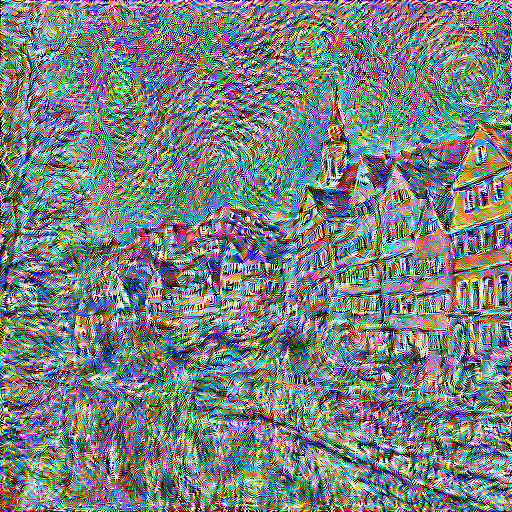

In [26]:
with torch.no_grad():
    trainable_input.clamp_(0, 1)
    trainable_input_cpu = trainable_input.detach().cpu().numpy()
trainable_input_cpu *= 255.0
trainable_input_cpu = trainable_input_cpu.astype(np.uint8)
trainable_input_cpu = np.squeeze(trainable_input_cpu)
trainable_input_cpu = np.swapaxes(trainable_input_cpu, 0, 2)

cv2.imwrite("/kaggle/working/output5.png", cv2.cvtColor(trainable_input_cpu, cv2.COLOR_RGB2BGR))
# cv2.imwrite("/kaggle/working/output5.png", trainable_input_cpu)

from IPython.display import Image
img = Image(filename='/kaggle/working/output5.png')
display(img)

Now we rewrite the code in a more concise manner

In [6]:
!pip install albumentations

import numpy as np
from PIL import Image
import glob
import cv2
import os
from os.path import join as pjoin
from pdb import set_trace
import copy
import scipy

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset, WeightedRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
from torchvision.models.alexnet import model_urls
try:
  from torchvision.models.utils import load_state_dict_from_url
except ImportError:
  from torch.hub import load_state_dict_from_url

import albumentations as albu
from albumentations.pytorch import ToTensorV2

# Detect if we have a GPU available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from pdb import set_trace
from collections import OrderedDict


class NeuralStyleTransferModel(nn.Module):
    """ Code for a neural algorithm of artistic style, wrapped in a class.
    References:
    [1] Gatys, Leon & Ecker, Alexander & Bethge, Matthias. (2015).
        A Neural Algorithm of Artistic Style. arXiv. 10.1167/16.12.326.     
    """
    def __init__(self):  
        super(NeuralStyleTransferModel, self).__init__()
        
        fhooks = {}        
        activation = OrderedDict()
        
        # Load pre-trained VGG19 model, remove FC layers and replace max-pooling by average pooling        
        pretrained_model = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)
        pretrained_model.classifier = nn.Identity()
        pretrained_model.features.requires_grad_(False)
        for i, layer in pretrained_model.features.named_children():
            if isinstance(layer, torch.nn.MaxPool2d):
                pretrained_model.features[int(i)] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        
        # Get outputs of intermediate layers
        pretrained_model.features[0].register_forward_hook(self.forward_hook('conv1_1'))
        pretrained_model.features[5].register_forward_hook(self.forward_hook('conv2_1'))
        pretrained_model.features[10].register_forward_hook(self.forward_hook('conv3_1'))
        pretrained_model.features[19].register_forward_hook(self.forward_hook('conv4_1'))
        pretrained_model.features[28].register_forward_hook(self.forward_hook('conv5_1'))
        pretrained_model.features[21].register_forward_hook(self.forward_hook('conv4_2')) # For content loss
        
        # Send model weights to CUDA
        pretrained_model.cuda()
        
        self.fhooks = fhooks
        self.activation = activation
        self.pretrained_model = pretrained_model
        
    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.activation[layer_name] = output
        return hook
    
    def forward(self, x):
        out = self.pretrained_model(x)
        return out, self.activation

class ContentLoss(nn.Module):
    """ Module to calculate the content loss described in the paper"""
    def __init__(self):
        super(ContentLoss, self).__init__()

    def forward(self, Pl, Fl):
        rms_loss = nn.MSELoss()
        loss_val = rms_loss(Pl, Fl)
        return loss_val

class StyleLoss(nn.Module):
    """ Module to calculate the style loss described in the paper"""
    def __init__(self):
        super(StyleLoss, self).__init__()

    def forward(self, Pl, Fl):
        Pl = Pl.reshape(Pl.shape[0], Pl.shape[1], -1)
        Fl = Fl.reshape(Fl.shape[0], Fl.shape[1], -1)

        n_filter = Pl.shape[1]
        feature_map_size = Pl.shape[2]

        Pl_gram = torch.bmm(Pl, torch.swapaxes(Pl, 2, 1))
        Fl_gram = torch.bmm(Fl, torch.swapaxes(Pl, 2, 1))

        rms_loss = nn.MSELoss()
        loss_val = rms_loss(Pl_gram, Fl_gram)
        loss_val /= 2.0
        loss_val /= (1.0* (n_filter*feature_map_size))
        loss_val *= wl
        
        return loss_val
    
# Hyperparameter settings
n_epoch = 10000
learning_rate = 0.01
# learning_rate = 0.0001
wl_list = [1/5, 1/5, 1/5, 1/5, 1/5]
# wl_list = [50, 1/5, 1/5, 1/5, 1/5]
# wl_list = [1.5, 0.8, 0.25, 0.25, 0.25]
# wl_list = [1e3/n**2 for n in [64,128,256,512,512]]
# wl_list = [0.25, 0.25, 0.25, 0.8, 2.5]
# wl_list = [0.5, 0.5, 0.8, 5, 1000]
# wl_list = [100, 0.8, 0.25, 0.25, 0.25]
# wl_list = [1, 0, 0, 0, 0]
imsize = 512
#alpha = 0.0001
# alpha = 1e-1
alpha = 1
beta = 1
content_layer_list = ["conv4_2"]
style_layer_list = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]

# Load the style and content images
# dataset_path = "/kaggle/input/datasetstyle/dataset"
# content_img = cv2.imread(pjoin(dataset_path, "content_image", "Tuebingen_Neckarfront.jpg"))
# style_img = cv2.imread(pjoin(dataset_path, "style_image", "van_gogh_the_scream.jpg"))

dataset_path = "/kaggle/input/mydataset/dataset"
content_img = cv2.imread(pjoin(dataset_path, "content_image", "Tuebingen_Neckarfront.jpg"))
style_img = cv2.imread(pjoin(dataset_path, "style_image", "vangogh_starry_night.jpg"))

content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)
style_img = cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB)

content_img = cv2.resize(content_img, (imsize, imsize), interpolation=cv2.INTER_CUBIC)
style_img = cv2.resize(style_img, (imsize, imsize), interpolation=cv2.INTER_CUBIC)

content_img = content_img.astype(np.float32)
style_img = style_img.astype(np.float32)
content_img /= 255.0
style_img /= 255.0

content_img = content_img[np.newaxis, :, :, :]
style_img = style_img[np.newaxis, :, :, :]

content_img_torch = torch.from_numpy(content_img)
style_img_torch = torch.from_numpy(style_img)

content_img_torch = torch.swapaxes(content_img_torch, 3, 1)
style_img_torch = torch.swapaxes(style_img_torch, 3, 1)

# Set up trainable input parameter here
trainable_input = nn.Parameter(torch.rand((1, 3, imsize, imsize)).clone().requires_grad_(True).cuda())
# trainable_input = nn.Parameter(content_img_torch.clone().requires_grad_(True).cuda())

content_img_torch = content_img_torch.cuda()
style_img_torch = style_img_torch.cuda()

# Set up optimizer
opt = optim.Adam([trainable_input.requires_grad_()], lr=learning_rate)

# Dictionaries to store intermedate outputs
style_dict = {}
content_dict = {}
input_dict = {}

# Initialize the neural style transfer model
nst_model = NeuralStyleTransferModel()

# We only need to send the content and style image through the pretrained network once
# pretrained_model.cuda()
out, activation = nst_model(content_img_torch)
content_dict = activation.copy()
out, activation = nst_model(style_img_torch)
style_dict = activation.copy()    
    
for epoch_idx in range(1, n_epoch+1):
    # correct the values of updated input image
    with torch.no_grad():
        trainable_input.clamp_(0, 1)

    # Let the trainable input pass through 
    out, activation = nst_model(trainable_input)
    input_dict = activation.copy()

    # Calculate the content loss
    content_loss = 0
    for content_layer in content_layer_list:
        Pl = content_dict[content_layer]
        Fl = input_dict[content_layer]
        
        content_loss_func = ContentLoss()
        loss_val = content_loss_func(Pl, Fl)
        
        content_loss += loss_val  

    # Now, let the style image run through, then we calculate the style loss
    out, activation = nst_model(style_img_torch)
    style_dict = activation.copy()

    style_loss = 0
    for style_layer, wl in zip(style_layer_list, wl_list):
        Pl = style_dict[content_layer]
        Fl = input_dict[content_layer]

        style_loss_func = StyleLoss()
        loss_val = style_loss_func(Pl, Fl)

        style_loss += loss_val

    # Calculate total loss and update the trainable parameters accordingly
    total_loss = alpha*content_loss + beta*style_loss

    opt.zero_grad()
    total_loss.backward()  
    opt.step()

    if (epoch_idx % 50 == 0):
        print("Epoch: %d. Loss: %f" % (epoch_idx, total_loss.item()))
        # print(total_loss)      

Epoch: 50. Loss: 0.075948
Epoch: 100. Loss: 0.042805
Epoch: 150. Loss: 0.034982
Epoch: 200. Loss: 0.031951
Epoch: 250. Loss: 0.030378
Epoch: 300. Loss: 0.029452
Epoch: 350. Loss: 0.028849
Epoch: 400. Loss: 0.028427
Epoch: 450. Loss: 0.028111
Epoch: 500. Loss: 0.027865
Epoch: 550. Loss: 0.027674
Epoch: 600. Loss: 0.027539
Epoch: 650. Loss: 0.027399
Epoch: 700. Loss: 0.027284
Epoch: 750. Loss: 0.027195
Epoch: 800. Loss: 0.027132
Epoch: 850. Loss: 0.027046
Epoch: 900. Loss: 0.027016
Epoch: 950. Loss: 0.026938
Epoch: 1000. Loss: 0.026884
Epoch: 1050. Loss: 0.026865
Epoch: 1100. Loss: 0.026809
Epoch: 1150. Loss: 0.026771
Epoch: 1200. Loss: 0.026741
Epoch: 1250. Loss: 0.026713
Epoch: 1300. Loss: 0.026692
Epoch: 1350. Loss: 0.026667
Epoch: 1400. Loss: 0.026635
Epoch: 1450. Loss: 0.026635
Epoch: 1500. Loss: 0.026595
Epoch: 1550. Loss: 0.026578
Epoch: 1600. Loss: 0.026573
Epoch: 1650. Loss: 0.026544
Epoch: 1700. Loss: 0.026538
Epoch: 1750. Loss: 0.026553
Epoch: 1800. Loss: 0.026508
Epoch: 1850.

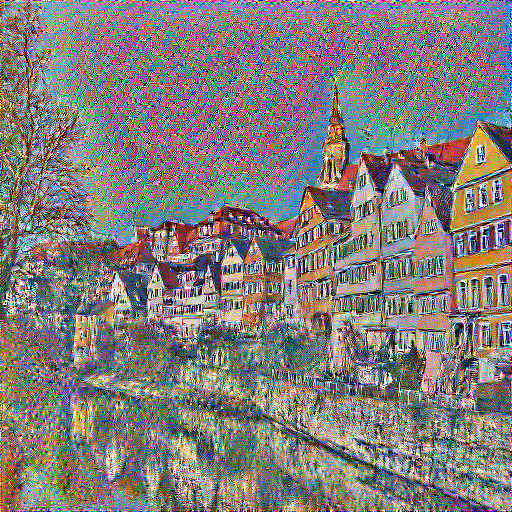

In [7]:
with torch.no_grad():
    trainable_input.clamp_(0, 1)
    trainable_input_cpu = trainable_input.detach().cpu().numpy()
trainable_input_cpu *= 255.0
trainable_input_cpu = trainable_input_cpu.astype(np.uint8)
trainable_input_cpu = np.squeeze(trainable_input_cpu)
trainable_input_cpu = np.swapaxes(trainable_input_cpu, 0, 2)

cv2.imwrite("/kaggle/working/output10.png", cv2.cvtColor(trainable_input_cpu, cv2.COLOR_RGB2BGR))

from IPython.display import Image
img = Image(filename='/kaggle/working/output10.png')
display(img)